# Hit dose analysis

In [ ]:
# imports
import glob
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.insert(0, '../../software/finemo_gpu/src/finemo')
from finemo.data_io import *
from finemo.evaluation import *
from scipy.stats import entropy
from matplotlib import rcParams
import logomaker
rcParams['pdf.fonttype'] = 42  # Embed fonts (Type 3 or Type 42) otherwise can't edit text in illustrator

In [75]:
refdict = {"SPI1": "ETS_single__merged_pattern_0",
            # "ELF1": "ETS_single_1__merged_pattern_0",
            "ELF1": "ETS_single_2__merged_pattern_0",
            "KLF1": "SP.KLF_single_1__merged_pattern_0",
            "KLF4": "SP.KLF_single_1__merged_pattern_0",
            "ALX4": "ALX.HD__merged_pattern_0",
            "IRF4": "IRF_single__merged_pattern_0",
            "LEF1": "LEF_single__merged_pattern_0",
            "OCT4": "POU_single__merged_pattern_0",
            "SOX2": "SOX_single__merged_pattern_0",
            "SP4": "SP.KLF_single__merged_pattern_0",
            "TCF3": "bHLH_single__merged_pattern_0"}

In [ ]:
base_dir = "../../"
dose_ls = ["d005", "d025", "d050", "d075", "d100"]
outdir = f"{base_dir}/output/02-atac/16/"
plotdir = f"{base_dir}/plots/02-atac/16/"
os.makedirs(outdir, exist_ok=True)
os.makedirs(plotdir, exist_ok=True)

## single TF

In [ ]:
# user inputs
TF = "ELF1"
keyword = refdict[TF]
# keyword = "ETS_TT__merged_pattern_0" # this is the keyword used to filter motif hits 

hits_paths = {d: glob.glob(f"{base_dir}/output/04-chrombpnet/output/models/fold_0/*{TF}_{d}/finemo_out/{TF}/hits/hits.tsv")[0] for d in dose_ls}
hits_paths

In [77]:
# check to make sure all hits paths exist
assert all([os.path.exists(f) for f in list(hits_paths.values())])

### read motif hits

In [78]:
def load_hits(path, filter=False, filter_keyword=None):
    # path: path to hits.tsv output from finemo-gpu output
    hits = pd.read_csv(path, sep="\t")
    hits["hit_name"] = hits["chr"] + "_" + hits["start"].astype(str) + "_" + hits["end"].astype(str)
    if (filter == True) and (filter_keyword != None):
        hits = hits[hits.motif_name.str.contains(filter_keyword)]
    return(hits)

In [79]:
hits_all = load_hits(hits_paths["d100"], filter=True, filter_keyword=keyword)
hits_all["hit_d100"] = 1
print(hits_all.shape)
hits_all.head()

(1042641, 15)


,chr,start,end,start_untrimmed,end_untrimmed,motif_name,hit_coefficient,hit_coefficient_global,hit_correlation,hit_importance,strand,peak_name,peak_id,hit_name,hit_d100
32,chr1,778914,778921,778903,778933,pos_patterns.ETS_single_2__merged_pattern_0,0.671421,0.000036,0.936849,0.039534,+,HEK293T_P3A12_GFP_d100_peak_17,1,chr1_778914_778921,1
67,chr1,826764,826771,826753,826783,pos_patterns.ETS_single_2__merged_pattern_0,0.800289,0.000022,0.765905,0.052776,+,HEK293T_P3G7_SPI1_d100_peak_10,4,chr1_826764_826771,1
101,chr1,827764,827771,827753,827783,pos_patterns.ETS_single_2__merged_pattern_0,3.833148,0.000092,0.939201,0.040887,+,HEK293T_P3F10_SPI1_d025_peak_18,5,chr1_827764_827771,1
102,chr1,838304,838311,838292,838322,pos_patterns.ETS_single_2__merged_pattern_0,7.960446,0.000073,0.939476,0.036187,-,HEK293T_P2E11_TCF3_d005_peak_4,6,chr1_838304_838311,1
116,chr1,869850,869857,869838,869868,pos_patterns.ETS_single_2__merged_pattern_0,0.395344,0.000017,0.822499,0.038164,-,HEK293T_P3A12_GFP_d100_peak_56,7,chr1_869850_869857,1


### group motifs by when they get called by finemo as hits
start with all hits called at highest dose, then annotate if these are also hits in each of the lower doses.

In [80]:
for dose in ["d075", "d050", "d025", "d005"]:
    print(dose)
    hits = load_hits(hits_paths[dose], filter=True, filter_keyword=keyword)
    hits[f"hit_{dose}"] = 1
    hits_all = pd.merge(hits_all, hits, on=["chr", "start", "end", "start_untrimmed", "end_untrimmed", "motif_name", "strand", "peak_name",  "peak_id", "hit_name"], 
                        how="left", suffixes=["", f"_{dose}"])


d075


d050
d025
d005


In [81]:
hits_all["hit_dose"] = "d100"
hits_all.loc[hits_all.hit_d075==1, "hit_dose"] = "d075"
hits_all.loc[(hits_all.hit_dose=="d075") & (hits_all.hit_d050==1), "hit_dose"] = "d050"
hits_all.loc[(hits_all.hit_dose=="d050") & (hits_all.hit_d025==1), "hit_dose"] = "d025"
hits_all.loc[(hits_all.hit_dose=="d025") & (hits_all.hit_d005==1), "hit_dose"] = "d005"

In [82]:
hits_all.hit_dose.value_counts()

d100    371010
d075    305093
d050    169731
d025    159506
d005     37301
Name: hit_dose, dtype: int64

In [ ]:
hits_all.to_csv(f"{outdir}/{TF}_{keyword}_hit_dose.csv")

In [ ]:
hits_all = pd.read_csv(f"{outdir}/{TF}_{keyword}_hit_dose.csv")
hits_all.head()

,Unnamed: 0,chr,start,end,start_untrimmed,end_untrimmed,motif_name,hit_coefficient,hit_coefficient_global,hit_correlation,...,hit_coefficient_global_d025,hit_correlation_d025,hit_importance_d025,hit_d025,hit_coefficient_d005,hit_coefficient_global_d005,hit_correlation_d005,hit_importance_d005,hit_d005,hit_dose
0,0,chr1,778914,778921,778903,778933,pos_patterns.ETS_single_2__merged_pattern_0,0.671421,0.000036,0.936849,...,0.000100,0.824245,0.072975,1.0,NaN,NaN,NaN,NaN,NaN,d100
1,1,chr1,826764,826771,826753,826783,pos_patterns.ETS_single_2__merged_pattern_0,0.800289,0.000022,0.765905,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,d100
2,2,chr1,827764,827771,827753,827783,pos_patterns.ETS_single_2__merged_pattern_0,3.833148,0.000092,0.939201,...,0.000226,0.950143,0.069433,1.0,0.841557,0.000028,0.932079,0.02862,1.0,d005
3,3,chr1,838304,838311,838292,838322,pos_patterns.ETS_single_2__merged_pattern_0,7.960446,0.000073,0.939476,...,0.000002,0.789010,0.016379,1.0,NaN,NaN,NaN,NaN,NaN,d025
4,4,chr1,869850,869857,869838,869868,pos_patterns.ETS_single_2__merged_pattern_0,0.395344,0.000017,0.822499,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,d100


### generate an upset plot

In [85]:
# outer merge instead of left merge
hits_all = load_hits(hits_paths["d100"], filter=True, filter_keyword=keyword)
hits_all["hit_d100"] = True
for dose in ["d075", "d050", "d025", "d005"]:
    print(dose)
    hits = load_hits(hits_paths[dose], filter=True, filter_keyword=keyword)
    hits[f"hit_{dose}"] = True
    hits_all = pd.merge(hits_all, hits, on=["chr", "start", "end", "hit_name"], 
                        how="outer", suffixes=["", f"_{dose}"])
hits_all.fillna(False, inplace=True)

d075
d050
d025
d005


In [86]:
hits_all.head()

,chr,start,end,start_untrimmed,end_untrimmed,motif_name,hit_coefficient,hit_coefficient_global,hit_correlation,hit_importance,...,end_untrimmed_d005,motif_name_d005,hit_coefficient_d005,hit_coefficient_global_d005,hit_correlation_d005,hit_importance_d005,strand_d005,peak_name_d005,peak_id_d005,hit_d005
0,chr1,778914,778921,778903.0,778933.0,pos_patterns.ETS_single_2__merged_pattern_0,0.671421,0.000036,0.936849,0.039534,...,False,False,False,False,False,False,False,False,False,False
1,chr1,826764,826771,826753.0,826783.0,pos_patterns.ETS_single_2__merged_pattern_0,0.800289,0.000022,0.765905,0.052776,...,False,False,False,False,False,False,False,False,False,False
2,chr1,827764,827771,827753.0,827783.0,pos_patterns.ETS_single_2__merged_pattern_0,3.833148,0.000092,0.939201,0.040887,...,827783.0,pos_patterns.ETS_single_2__merged_pattern_0,0.841557,0.000028,0.932079,0.02862,+,HEK293T_P3F10_SPI1_d025_peak_18,5.0,True
3,chr1,838304,838311,838292.0,838322.0,pos_patterns.ETS_single_2__merged_pattern_0,7.960446,0.000073,0.939476,0.036187,...,False,False,False,False,False,False,False,False,False,False
4,chr1,869850,869857,869838.0,869868.0,pos_patterns.ETS_single_2__merged_pattern_0,0.395344,0.000017,0.822499,0.038164,...,False,False,False,False,False,False,False,False,False,False


In [87]:
hits_all.set_index(["hit_d005", "hit_d025", "hit_d050", "hit_d075", "hit_d100"], inplace=True)
hits_all.head()

chr   start     end  \
hit_d005 hit_d025 hit_d050 hit_d075 hit_d100                         
False    True     True     False    True      chr1  778914  778921   
         False    False    False    True      chr1  826764  826771   
True     True     True     True     True      chr1  827764  827771   
False    True     True     True     True      chr1  838304  838311   
         False    False    False    True      chr1  869850  869857   

                                             start_untrimmed end_untrimmed  \
hit_d005 hit_d025 hit_d050 hit_d075 hit_d100                                 
False    True     True     False    True            778903.0      778933.0   
         False    False    False    True            826753.0      826783.0   
True     True     True     True     True            827753.0      827783.0   
False    True     True     True     True            838292.0      838322.0   
         False    False    False    True            869838.0      869868.0   

                                                                               motif_name  \
hit_d005 hit_d025 hit_d050 hit_d075 hit_d100                                                
False    True     True     False    True      pos_patterns.ETS_single_2__merged_pattern_0   
         False    False    False    True      pos_patterns.ETS_single_2__merged_pattern_0   
True     True     True     True     True      pos_patterns.ETS_single_2__merged_pattern_0   
False    True     True     True     True      pos_patterns.ETS_single_2__merged_pattern_0   
         False    False    False    True      pos_patterns.ETS_single_2__merged_pattern_0   

                                             hit_coefficient  \
hit_d005 hit_d025 hit_d050 hit_d075 hit_d100                   
False    True     True     False    True            0.671421   
         False    False    False    True            0.800289   
True     True     True     True     True            3.833148   
False    True     True     True     True            7.960446   
         False    False    False    True            0.395344   

                                             hit_coefficient_global  \
hit_d005 hit_d025 hit_d050 hit_d075 hit_d100                          
False    True     True     False    True                   0.000036   
         False    False    False    True                   0.000022   
True     True     True     True     True                   0.000092   
False    True     True     True     True                   0.000073   
         False    False    False    True                   0.000017   

                                             hit_correlation hit_importance  \
hit_d005 hit_d025 hit_d050 hit_d075 hit_d100                                  
False    True     True     False    True            0.936849       0.039534   
         False    False    False    True            0.765905       0.052776   
True     True     True     True     True            0.939201       0.040887   
False    True     True     True     True            0.939476       0.036187   
         False    False    False    True            0.822499       0.038164   

                                              ... start_untrimmed_d005  \
hit_d005 hit_d025 hit_d050 hit_d075 hit_d100  ...                        
False    True     True     False    True      ...                False   
         False    False    False    True      ...                False   
True     True     True     True     True      ...             827753.0   
False    True     True     True     True      ...                False   
         False    False    False    True      ...                False   

                                             end_untrimmed_d005  \
hit_d005 hit_d025 hit_d050 hit_d075 hit_d100                      
False    True     True     False    True                  False   
         False    False    False    True                  False   
True     True     True     True     True               827783.0   
Fa

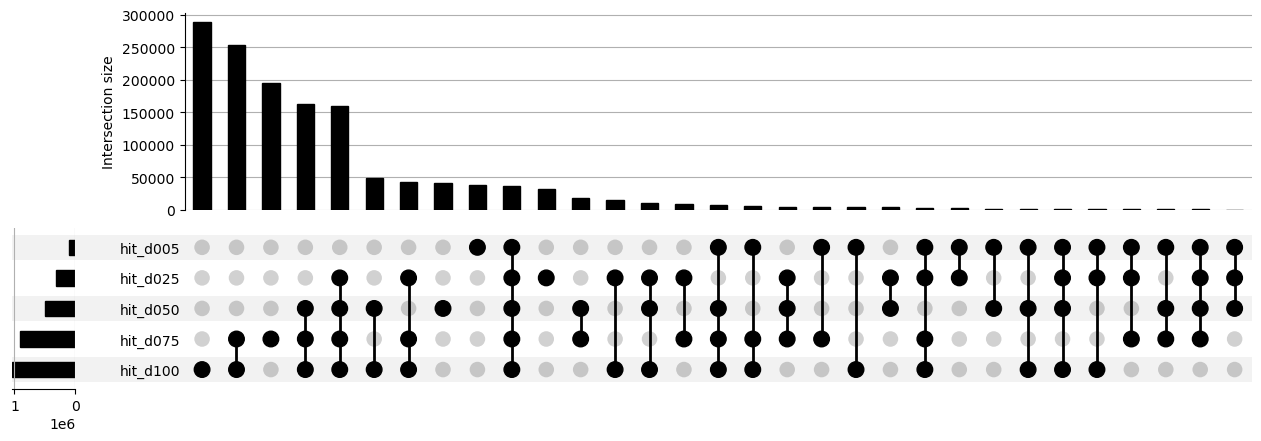

In [ ]:
from upsetplot import UpSet, plot
UpSet(hits_all, subset_size="count",sort_by="cardinality").plot()
plt.savefig(f"{plotdir}/upset_{TF}_{keyword}_hit_dose.pdf")


### plot pileups for each hit dose group

In [ ]:
hits = pd.read_csv(f"{outdir}/{TF}_{keyword}_hit_dose.csv")
hits["is_revcomp"] = (hits.strand=="-")
hits.head()

,Unnamed: 0,chr,start,end,start_untrimmed,end_untrimmed,motif_name,hit_coefficient,hit_coefficient_global,hit_correlation,...,hit_correlation_d025,hit_importance_d025,hit_d025,hit_coefficient_d005,hit_coefficient_global_d005,hit_correlation_d005,hit_importance_d005,hit_d005,hit_dose,is_revcomp
0,0,chr1,778914,778921,778903,778933,pos_patterns.ETS_single_2__merged_pattern_0,0.671421,0.000036,0.936849,...,0.824245,0.072975,1.0,NaN,NaN,NaN,NaN,NaN,d100,False
1,1,chr1,826764,826771,826753,826783,pos_patterns.ETS_single_2__merged_pattern_0,0.800289,0.000022,0.765905,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,d100,False
2,2,chr1,827764,827771,827753,827783,pos_patterns.ETS_single_2__merged_pattern_0,3.833148,0.000092,0.939201,...,0.950143,0.069433,1.0,0.841557,0.000028,0.932079,0.02862,1.0,d005,False
3,3,chr1,838304,838311,838292,838322,pos_patterns.ETS_single_2__merged_pattern_0,7.960446,0.000073,0.939476,...,0.789010,0.016379,1.0,NaN,NaN,NaN,NaN,NaN,d025,True
4,4,chr1,869850,869857,869838,869868,pos_patterns.ETS_single_2__merged_pattern_0,0.395344,0.000017,0.822499,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,d100,True


In [ ]:
genome = f"{base_dir}/data/chrombp_resources/hg38.fa"
hg38 = pyfaidx.Fasta(genome)

def get_seq_polar(hits, genome, pad=0):
    """
    fetches sequence from a given genome.
    """
    vals = []
    for i in range(hits.shape[0]):
        r = hits[i]
        sequence_raw = genome[r['chr'][0]][(r['start'][0]-pad):(r['end'][0]+pad)]
        if r['is_revcomp'][0]:
            sequence = str(sequence_raw.reverse.complement.seq)
        else:
            sequence = str(sequence_raw)
        vals.append(sequence)
    return vals

def get_seq(hits, genome, pad=0):
    """
    fetches sequence from a given genome.
    """
    vals = []
    for i in range(hits.shape[0]):
        r = hits.iloc[i]
        sequence_raw = genome[r['chr']][(r['start']-pad):(r['end']+pad)]
        if r['is_revcomp']:
            sequence = str(sequence_raw.reverse.complement.seq)
        else:
            sequence = str(sequence_raw)
        vals.append(sequence)
    return vals

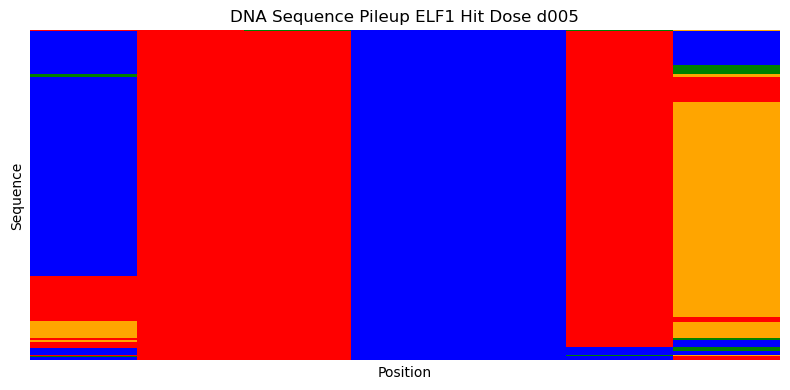

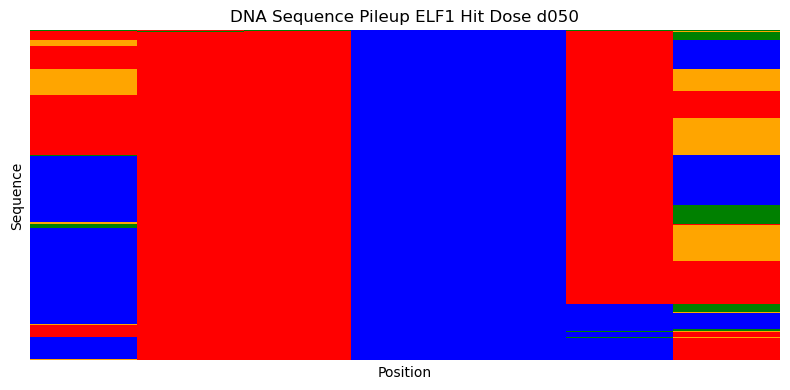

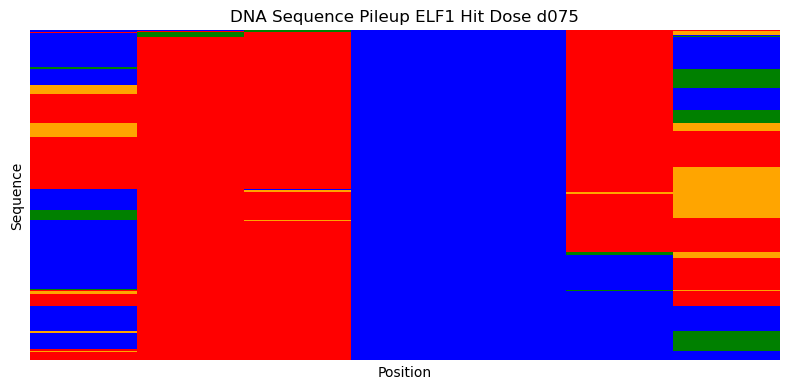

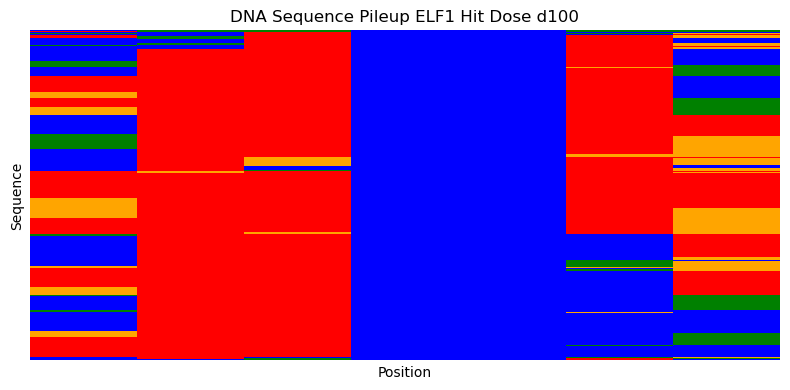

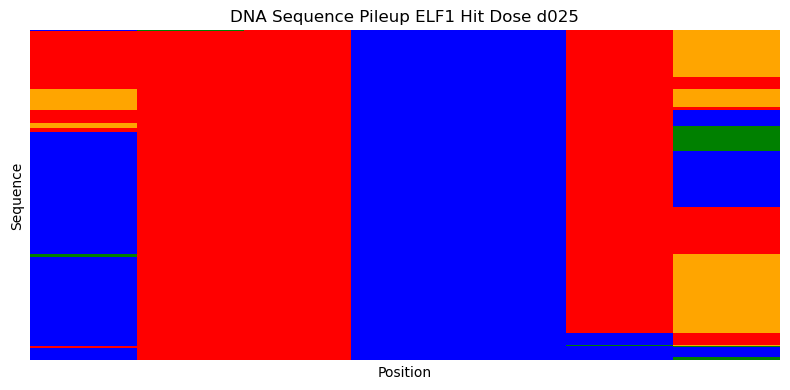

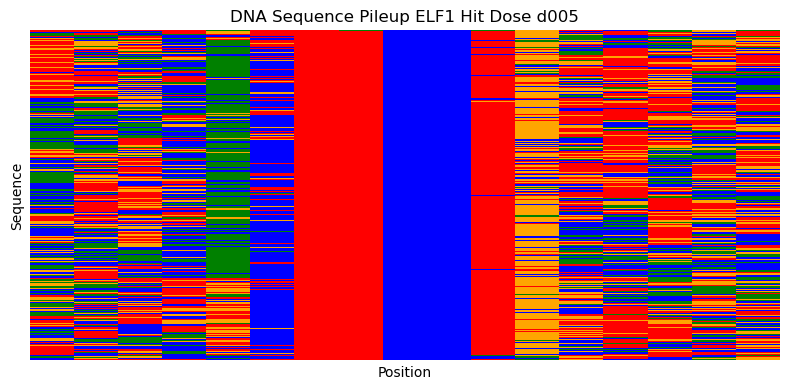

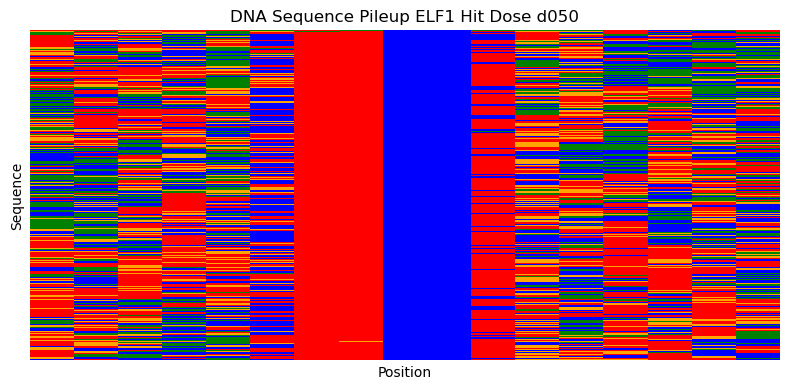

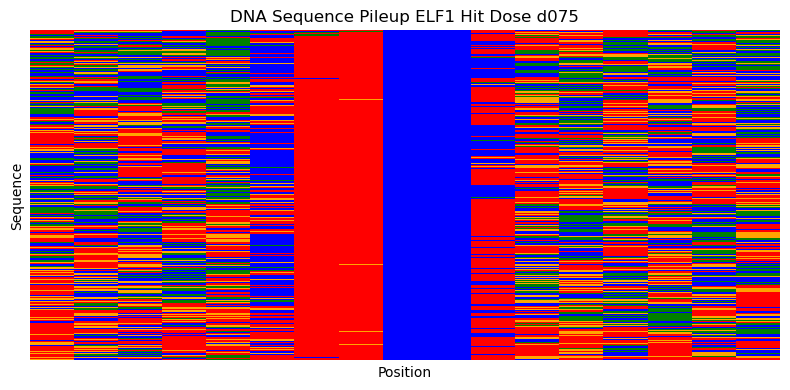

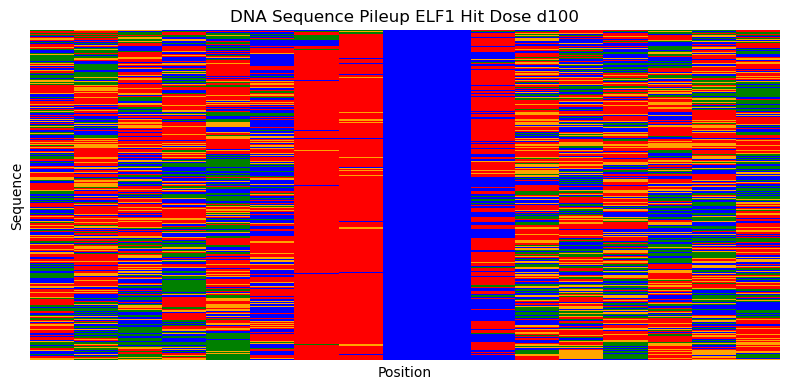

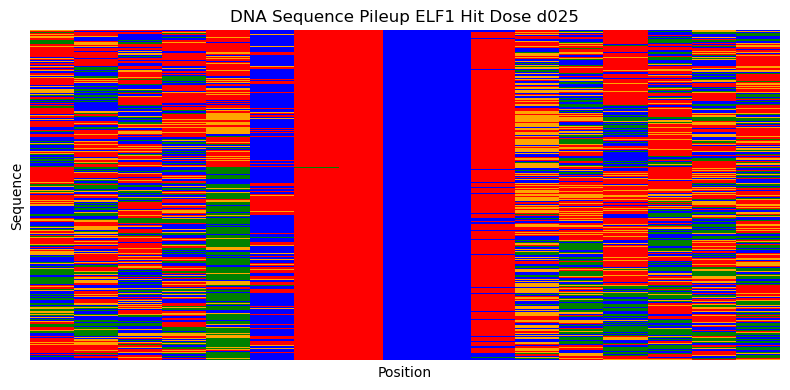

In [ ]:
from matplotlib.colors import ListedColormap

# pad=0 # number of bases around each side of motif to include in pileup
for pad in [0,5]:
    for m in set(hits["hit_dose"]):
        plot = f"{plotdir}/{TF}_{keyword}_cwms/{m}"
        os.makedirs(plot, exist_ok=True)
        subhits = hits[hits.hit_dose==m]
        # sample 1000 motifs for speed
        np.random.seed(16)
        idx = np.random.randint(0, len(subhits)-1, size=1000)
        subhits = subhits.iloc[idx]
        sequences = get_seq(subhits, hg38, pad=pad)

        # Define colors for nucleotides
        nucleotide_colors = {
            "A": "green",
            "T": "red",
            "G": "orange",
            "C": "blue",
            "N": "gray",
        }

        # Create a dynamic colormap for only the nucleotides present in the sequences
        unique_nucleotides = sorted(set("".join(sequences)))
        present_mapping = {nuc: idx for idx, nuc in enumerate(unique_nucleotides)}
        present_colors = [nucleotide_colors[nuc] for nuc in unique_nucleotides]
        colormap = ListedColormap(present_colors)

        # Convert sequences to a numeric matrix
        numeric_matrix = np.array([[present_mapping[nuc] for nuc in seq] for seq in sequences])

        # cluster the sequences
        from scipy.cluster.hierarchy import linkage, dendrogram
        linked = linkage(numeric_matrix, method="average")
        dend = dendrogram(linked, orientation="left", no_plot=True)
        # plt.gca().invert_yaxis()
        # plt.xticks([])
        # plt.yticks([])
        seq_order = dend["leaves"]

        # Plot the heatmap
        plt.figure(figsize=(8, 4))
        sns.heatmap(
            numeric_matrix[seq_order],
            annot=False,  # Set to True to annotate with letters
            cmap=colormap,  # Use custom colors
            cbar=False,  # Hide the color bar
        )

        # plt.yticks(ticks=range(len(seq_order)),labels=seq_order)
        plt.yticks([])
        plt.xticks([])
        plt.xlabel("Position")
        plt.ylabel("Sequence")
        plt.title(f"DNA Sequence Pileup {TF} Hit Dose {m}")
        plt.tight_layout()
        plt.savefig(f"{plot}/pileup_pad{pad}.pdf")
        plt.show()


### plot PWMs for each hit dose group  

In [92]:
from Bio import motifs
from Bio.Seq import Seq
def dna_sequences_to_pwm(sequences):
    """
    Converts a list of DNA sequences to a PWM.

    Args:
        sequences (list): A list of DNA sequences (strings).

    Returns:
        Bio.motifs.matrix.PositionWeightMatrix: The PWM.
    """
    # Create a Motif object from the sequences
    motif = motifs.create([Seq(s) for s in sequences])
    # Calculate the PWM
    pwm = motif.counts.normalize(pseudocounts=0.5) # Adding pseudocounts to avoid zero probabilities

    return pwm

        0      1      2      3      4      5      6      7      8      9     10     11     12     13     14     15     16
A:   0.26   0.22   0.17   0.16   0.63   0.01   0.00   0.00   0.00   0.00   0.01   0.04   0.12   0.14   0.18   0.18   0.19
C:   0.28   0.27   0.32   0.45   0.10   0.75   0.00   0.00   1.00   1.00   0.05   0.15   0.31   0.26   0.25   0.32   0.31
G:   0.19   0.20   0.22   0.15   0.17   0.06   0.00   0.00   0.00   0.00   0.00   0.72   0.23   0.14   0.20   0.24   0.23
T:   0.28   0.31   0.29   0.24   0.10   0.18   1.00   1.00   0.00   0.00   0.94   0.09   0.34   0.46   0.36   0.26   0.28

        0      1      2      3      4      5      6      7      8      9     10     11     12     13     14     15     16
A:   0.23   0.23   0.18   0.15   0.31   0.02   0.00   0.00   0.00   0.00   0.00   0.12   0.21   0.22   0.21   0.22   0.22
C:   0.25   0.27   0.27   0.31   0.23   0.58   0.00   0.00   1.00   1.00   0.17   0.28   0.29   0.24   0.27   0.28   0.30
G:   0.18   0.17   0.18

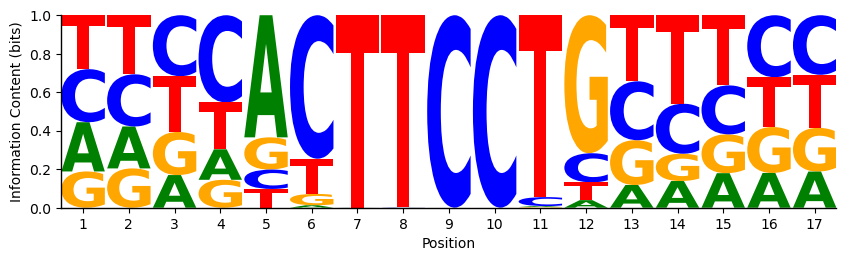

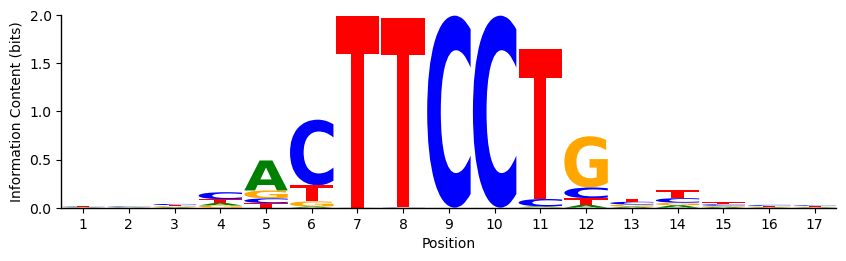

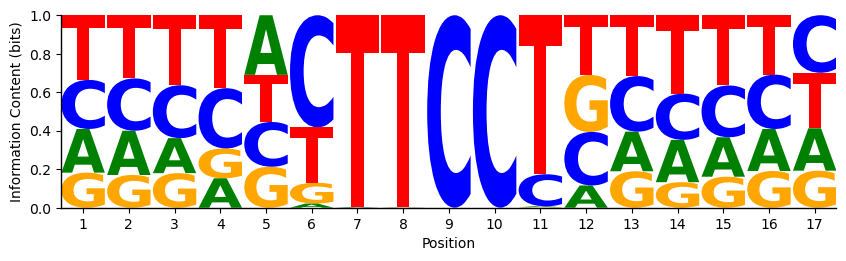

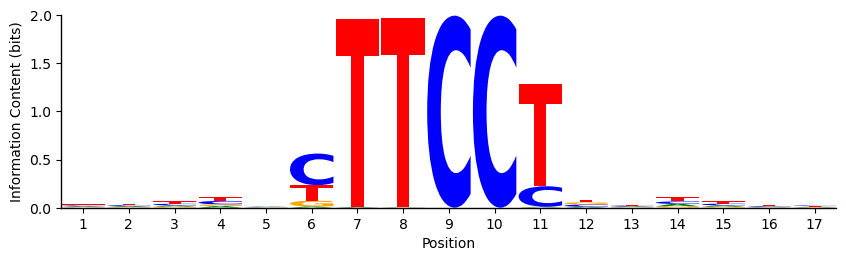

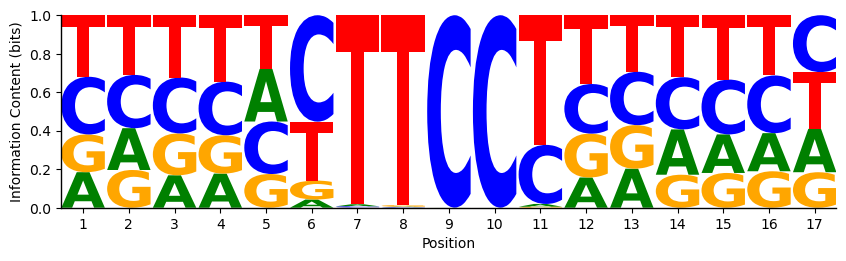

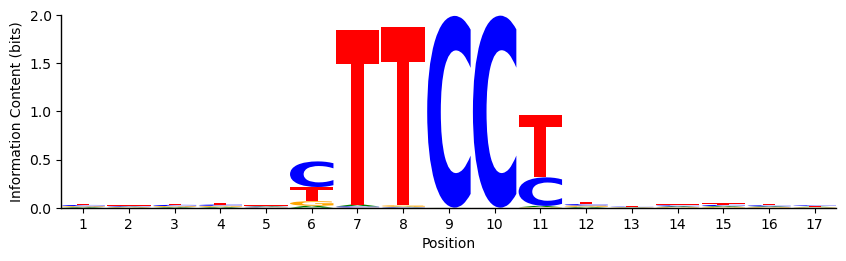

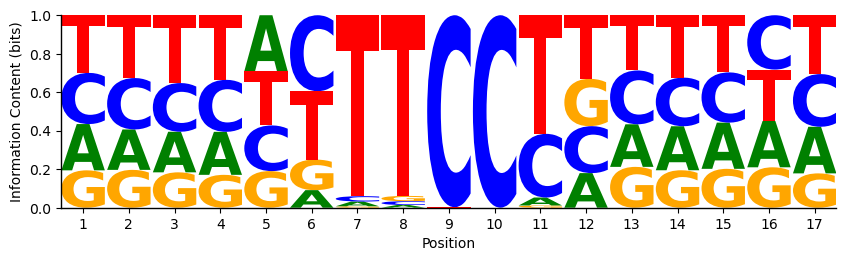

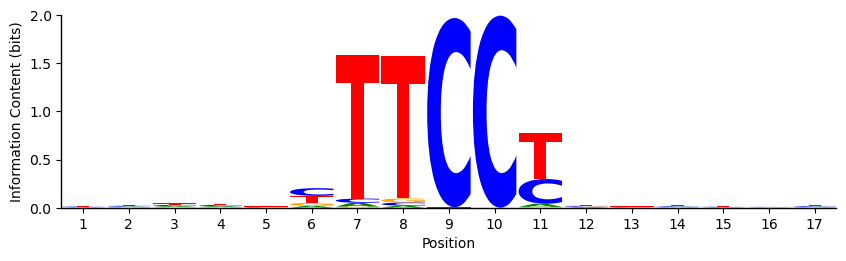

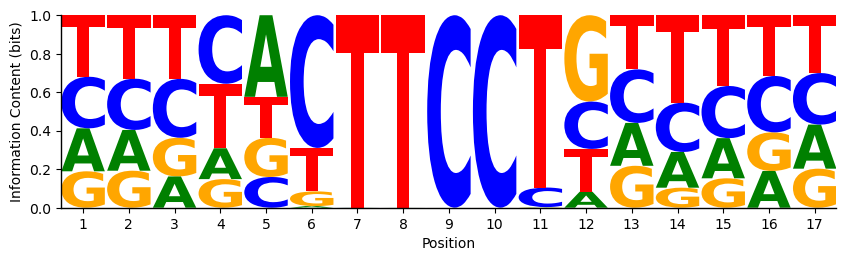

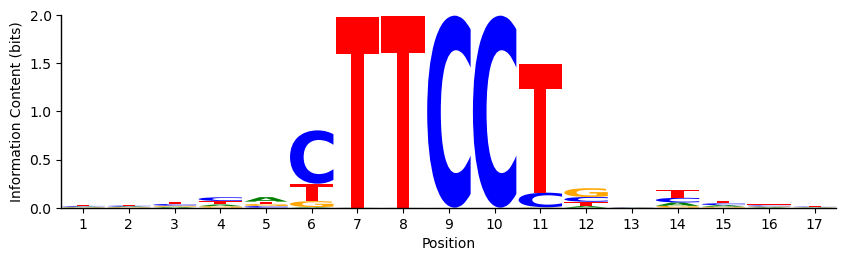

In [ ]:
pad = 5
for m in set(hits["hit_dose"]):
    subhits = hits[hits.hit_dose==m]
    # sample 5000 motifs for speed
    np.random.seed(16)
    idx = np.random.randint(0, len(subhits)-1, size=5000)
    subhits = subhits.iloc[idx]
    sequences = get_seq(subhits, hg38, pad=pad)

    pwm = dna_sequences_to_pwm(sequences)
    print(pwm)

    # Create a Pandas DataFrame from the PWM data
    pwm_df = pd.DataFrame(pwm)

    logo = logomaker.Logo(pwm_df)
    logo.style_glyphs()
    logo.style_spines(visible=False)
    logo.style_spines(spines=['left', 'bottom'], visible=True)
    logo.ax.set_xticks(range(len(pwm_df)))
    logo.ax.set_xticklabels(range(1, len(pwm_df) + 1))
    logo.ax.set_xlabel('Position')
    logo.ax.set_ylabel('Information Content (bits)')
    logo.fig.show()
        
    plt.savefig(f"{plotdir}/{TF}_{keyword}_cwms/{m}/pwm_pad{pad}_raw.pdf", dpi=150)

    # normalize for information content at each position
    pwm_df_norm = (pwm_df.transpose() * (2-entropy(pwm_df.transpose(), base=2))).transpose()
    pwm_df_norm.to_csv(f"{outdir}/{TF}_{keyword}_{m}_pwm_pad{pad}_norm.csv")

    logo = logomaker.Logo(pwm_df_norm)
    logo.style_glyphs()
    logo.style_spines(visible=False)
    logo.style_spines(spines=['left', 'bottom'], visible=True)
    logo.ax.set_xticks(range(len(pwm_df)))
    logo.ax.set_xticklabels(range(1, len(pwm_df) + 1))
    logo.ax.set_ylim(0, 2)
    logo.ax.set_xlabel('Position')
    logo.ax.set_ylabel('Information Content (bits)')
    logo.fig.show()
    plt.savefig(f"{plotdir}/{TF}_{keyword}_cwms/{m}/pwm_pad{pad}_norm.pdf", dpi=150)

### plot CWMs for each hit dose group

reading in hits again in the polar format to use finemo cwm functions

In [ ]:
# regions_path = glob.glob(f"../../output/04-chrombpnet/output/models/fold_0/HEK293T_*{TF}_d100/finemo_out/intermediate_inputs.npz")[0]
# peaks_path = glob.glob(f"../../output/04-chrombpnet/output/models/fold_0/HEK293T_*{TF}_d100/finemo_out/{TF}/hits/peaks_qc.tsv")[0]

# # takes 5m
# motif_width = 30
# sequences, contribs = load_regions_npz(regions_path)
# peaks = pl.scan_csv(peaks_path, has_header=True, separator="\t").collect()

# if len(contribs.shape) == 3:
#     regions = contribs * sequences
# elif len(contribs.shape) == 2:
#     regions = contribs[:,None,:] * sequences

In [ ]:
# hits_path = f"{outdir}/{TF}_{keyword}_hit_dose.csv"
# HITS_DTYPES = {
#     "chr": pl.Utf8,
#     "start": pl.UInt32,
#     "end": pl.UInt32,
#     "start_untrimmed": pl.UInt32,
#     "end_untrimmed": pl.UInt32,
#     "motif_name": pl.Utf8,
#     "hit_coefficient": pl.Float32,
#     "hit_coefficient_global": pl.Float32,
#     "hit_correlation": pl.Float32,
#     "hit_importance": pl.Float32,
#     "strand": pl.Utf8,
#     "peak_name": pl.Utf8,
#     "peak_id": pl.UInt32,
# }
# hits_df = (
#         pl.scan_csv(hits_path, separator=',', quote_char=None, dtypes=HITS_DTYPES)
#         .with_columns(pl.lit(1).alias("count"))
#     )

In [96]:
# hits = hits_df.collect()
# hits = hits.join(peaks, on="peak_name").with_columns(is_revcomp=(pl.col("strand") == '-'))
# hits.head()

In [97]:
# cwms = {}
# for m in set(hits["hit_dose"]):
#     cwms[m] = {"hits_fc": get_cwms(regions, hits.filter(pl.col("hit_dose")==m), motif_width)}
# cwms["all_d100_hits"] = {"hits_fc": get_cwms(regions, hits, motif_width)}
# cwms

In [ ]:
# def plot_cwms_bl(cwms, out_dir, alphabet=LOGO_ALPHABET, colors=LOGO_COLORS, font=LOGO_FONT):
#     for m, v in cwms.items():
#         motif_dir = os.path.join(out_dir, m)
#         os.makedirs(motif_dir, exist_ok=True)
#         for cwm_type, cwm in v.items():
#             output_path = os.path.join(motif_dir, f"{cwm_type}.png")

#             fig, ax = plt.subplots(figsize=(10,2))

#             plot_logo(ax, cwm, alphabet, colors=colors, font_props=font)

#             for name, spine in ax.spines.items():
#                 spine.set_visible(False)
            
#             plt.savefig(output_path, dpi=100)
#             plt.close(fig)

# plot_cwms_bl(cwms, out_dir=f"{plotdir}/{TF}_{keyword}_cwms")

# Run for all TFs
use jobscript 16b

# plot information content vs hit dose

In [ ]:
df_list = []
pad = 5
for TF in refdict.keys():
    keyword = refdict[TF]
    for m in dose_ls:
        pwm_df_norm = pd.read_csv(f"{outdir}/{TF}_{keyword}_{m}_pwm_pad{pad}_norm.csv")
        pwm_df_norm["hit_dose"] = m
        pwm_df_norm["TF"] = TF
        df_list.append(pwm_df_norm)

df = pd.concat(df_list, ignore_index=True)  # Concatenate all DataFrames

df["sum_per_pos"] = df["A"] + df["C"] + df["G"] + df["T"]

colpal = pd.read_csv("../utils/colpal_TF.tsv", sep="\t")
colpal.index = colpal.TF
tf_colors = colpal["color"].to_dict()

# method 1: avg info content per base
df_grouped = df.groupby(["TF", "hit_dose"], as_index=False).agg({"sum_per_pos": "mean"})
df_grouped["hit_dose"] = df_grouped["hit_dose"].str.extract(r'(\d+)').astype(int)
df_grouped["sum_per_pos_scaled"] = df_grouped.groupby("TF")["sum_per_pos"].transform(lambda x: (x - x.min()) / (x.max() - x.min()))

# absolute
plt.figure(figsize=(5, 5))
sns.lineplot(data=df_grouped, x="hit_dose", y="sum_per_pos", hue="TF", marker="o", palette=tf_colors)
plt.xlabel("Hit Dose")
plt.ylabel("Mean information content per pos (pad=5)")
plt.legend(title="TF", bbox_to_anchor=(1, 1), loc="upper right")
plt.tight_layout()
plt.show()
plt.savefig(f"{plotdir}/all_bits_vs_hitdose.pdf")

# scaled 0 to 1 per TF
plt.figure(figsize=(5, 5))
sns.lineplot(data=df_grouped, x="hit_dose", y="sum_per_pos_scaled", hue="TF", marker="o", palette=tf_colors)
plt.xlabel("Hit Dose")
plt.ylabel("Scaled mean information content per pos (pad=5)")
plt.legend(title="TF", bbox_to_anchor=(1, 1), loc="upper right")
plt.tight_layout()
plt.show()
plt.savefig(f"{plotdir}/all_bits_vs_hitdose_scaled.pdf")

# method 2: sum info content over all of motif (variable lengths)
df_grouped = df.groupby(["TF", "hit_dose"], as_index=False).agg({"sum_per_pos": "sum"})
df_grouped["hit_dose"] = df_grouped["hit_dose"].str.extract(r'(\d+)').astype(int)
df_grouped["sum_per_pos_scaled"] = df_grouped.groupby("TF")["sum_per_pos"].transform(lambda x: (x - x.min()) / (x.max() - x.min()))

# absolute
plt.figure(figsize=(5, 5))
sns.lineplot(data=df_grouped, x="hit_dose", y="sum_per_pos", hue="TF", marker="o", palette=tf_colors)
plt.xlabel("Hit Dose")
plt.ylabel("Sum information content (pad=5)")
plt.legend(title="TF", bbox_to_anchor=(1, 1), loc="upper right")
plt.tight_layout()
plt.show()
plt.savefig(f"{plotdir}/all_summed_bits_vs_hitdose.pdf")

# scaled 0 to 1 per TF
plt.figure(figsize=(5, 5))
sns.lineplot(data=df_grouped, x="hit_dose", y="sum_per_pos_scaled", hue="TF", marker="o", palette=tf_colors)
plt.xlabel("Hit Dose")
plt.ylabel("Scaled sum information content per pos (pad=5)")
plt.legend(title="TF", bbox_to_anchor=(1, 1), loc="upper right")
plt.tight_layout()
plt.show()
plt.savefig(f"{plotdir}/all_summed_bits_vs_hitdose_scaled.pdf")